In [1]:
from __future__ import print_function, absolute_import, unicode_literals
from gm.api import *
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sttools
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import datetime
# 用来正常显示中文标签        
plt.rcParams['font.sans-serif']=['SimHei'] 
#用来正常显示负号        
plt.rcParams['axes.unicode_minus']=False 
pd.set_option('display.max_rows',None)      #显示所有列 
pd.set_option('display.max_columns',None)   #显示所有行
pd.set_option('colheader_justify', 'center')    #  显示居中还是左边 

In [2]:
class myquant():
    def __init__(self,date= None):
        # 获取当前日期(不是交易日的话，返回最近一个交易日)
        self.current_date = datetime.datetime.now() if date is None else date
        if len(get_trading_dates(exchange='SZSE', start_date=self.current_date, end_date=self.current_date))==0:
            self.current_date = get_previous_trading_date(exchange='SZSE', date=self.current_date)
        self.current_date_str = self.current_date.strftime('%Y-%m-%d')
        # 获取上一个交易日
        self.last_date = get_previous_trading_date(exchange='SZSE', date=self.current_date)
        # 获取所有股票
        self.all_stocks,self.all_stocks_str = self.get_normal_stocks(self.current_date,new_days=0)
        # 计算当日收益
        self.stocks_rate = self.get_return()
        # 其他信息数据
        # 收盘价（除权）
        self.close  = history(symbol=self.all_stocks_str, frequency='1d', start_time=self.current_date,  end_time=self.current_date, fields='symbol, close', adjust=ADJUST_NONE, df= True)
        self.base_data = get_history_instruments(symbols=self.all_stocks, start_date=self.current_date, end_date=self.current_date, df=True)
        self.base_data = self.base_data.merge(self.close,on='symbol',how='left')
        self.close.set_index('symbol',inplace=True)
        # 单季度归母净利润
        self.quarter_net_profit = None
        # 单季度ROE及其报告日期
        self.quarter_ROE = None
        self.quarter_ROE_end_date = None
        # 单季度ROA及其报告日期
        self.quarter_ROA = None
        self.quarter_ROA_end_date = None
        # 一个月反转
        self.inversion_1month = None
        
    def plot_distribution(self):
        """绘制涨幅分布图"""
        # 计算各区间的股票数量
        rate_neg10 = len(self.base_data[(self.base_data['close']==self.base_data['lower_limit'])&(self.base_data['sec_level']==1)])# 跌停(不包含ST)
        rate_10 = len(self.base_data[(self.base_data['close']==self.base_data['upper_limit'])&(self.base_data['sec_level']==1)])# 涨停(不包含ST)
        is_suspended = len(self.base_data[(self.base_data['is_suspended']==1)])# 停牌
        rate_neg8t10 = len(self.stocks_rate[self.stocks_rate<=-0.08])# <=-8%
        rate_neg6t8 = len(self.stocks_rate[(self.stocks_rate<=-0.06)&(self.stocks_rate>-0.08)])# -8%至-6%
        rate_neg4t6 = len(self.stocks_rate[(self.stocks_rate<=-0.04)&(self.stocks_rate>-0.06)])# -6%至-4%
        rate_neg2t4 = len(self.stocks_rate[(self.stocks_rate<=-0.02)&(self.stocks_rate>-0.04)])# -4%至-2%
        rate_neg0t2 = len(self.stocks_rate[(self.stocks_rate<-0.00)&(self.stocks_rate>-0.02)])# -2%至-0%
        rate_0 = len(self.stocks_rate[(self.stocks_rate==0.00)])# 0%
        rate_0t2 = len(self.stocks_rate[(self.stocks_rate<=0.02)&(self.stocks_rate>0.00)])# 0%至2%
        rate_2t4 = len(self.stocks_rate[(self.stocks_rate<=0.04)&(self.stocks_rate>0.02)])# 2%至4%
        rate_4t6 = len(self.stocks_rate[(self.stocks_rate<=0.06)&(self.stocks_rate>0.04)])# 4%至6%
        rate_6t8 = len(self.stocks_rate[(self.stocks_rate<=0.08)&(self.stocks_rate>0.06)])# 6%至8%
        rate_8t10 = len(self.stocks_rate[self.stocks_rate>0.08])# >8%
        # 汇总统计
        down_num = rate_neg0t2+rate_neg2t4+rate_neg4t6+rate_neg6t8+rate_neg8t10+rate_neg10# 下跌
        none_num = rate_0# 平盘
        up_num = rate_0t2+rate_2t4+rate_4t6+rate_6t8+rate_8t10+rate_10# 上涨
        # 输出
        print('当前日期：{}'.format(self.current_date_str),end = '    ')
        print('赚钱效应：{:0.2f}%'.format(100*up_num/(up_num+down_num)))
        
        print('下跌：{:4}家'.format(down_num),end = '    ')
        print('平盘：{:4}家'.format(none_num),end = '    ')
        print('上涨：{:4}家'.format(up_num))
        
        print('跌停：{:4}家'.format(rate_neg10),end = '    ')
        print('停牌：{:4}家'.format(is_suspended),end = '    ')
        print('涨停：{:4}家'.format(rate_10))
        
        print('注：1、股票不包含北交所股票；\n    2、涨幅为0的股票包含在(-2%,0%]中；\n    3、部分涨跌停股票可能存在未彻底封板情况。')
        
        # 绘图
        plt.figure(figsize=(10,5))
        data_zf = [rate_neg10,rate_neg8t10,rate_neg6t8,rate_neg4t6,rate_neg2t4,rate_neg0t2,rate_0t2,rate_2t4,rate_4t6,rate_6t8,rate_8t10,rate_10]
        idx = np.arange(len(data_zf))
        colors = ['g']*6+['r']*6
        plt.bar(idx,data_zf,color=colors,zorder=10)
        for a,b in zip(idx, data_zf):            
            plt.text(a, b+max(data_zf)/100, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
        label = ['跌停  ','<=-8%','(-8%,-6%] ','(-6%,-4%] ','(-4%,2%] ','(-2%,0%) ','(0%,2%]','(2%,4%] ','(4%,6%] ','(6%,8%] ','>8%','涨停  ']
        plt.xticks(idx,label, rotation=45)
        plt.title('全市场涨跌分布({})'.format(self.current_date_str))
        plt.grid(axis='y',zorder=0)
        plt.show()
        
        
    def get_return(self):
        close  = history(symbol=self.all_stocks_str, frequency='1d', start_time=self.last_date,  end_time=self.current_date, fields='symbol, close, eob', adjust=ADJUST_PREV, df= True).set_index(['eob','symbol'])
        close = close.unstack()
        close.columns = close.columns.droplevel(level=0)
        rate = (close/close.shift(1)-1).iloc[-1,:]
        return rate
        
        
    def get_normal_stocks(self,date,new_days=365):
        """
        获取目标日期date的A股代码（剔除次新股）
        :param date：目标日期
        :param new_days:新股上市天数，默认为365天
        """
        if isinstance(date,str) and len(date)==10:
            date = datetime.datetime.strptime(date,"%Y-%m-%d")
        elif isinstance(date,str) and len(date)>10:
            date = datetime.datetime.strptime(date,"%Y-%m-%d %H:%M:%S")
        # 先剔除退市股、次新股和B股
        df_code = get_instrumentinfos(sec_types=SEC_TYPE_STOCK, fields='symbol, listed_date, delisted_date', df=True)
        df_code['listed_date'] = df_code['listed_date'].apply(lambda x:x.replace(tzinfo=None))
        df_code['delisted_date'] = df_code['delisted_date'].apply(lambda x:x.replace(tzinfo=None))
        all_stocks = [code for code in df_code[(df_code['listed_date']<=date-datetime.timedelta(days=new_days))&(df_code['delisted_date']>date)].symbol.to_list() if code[:6]!='SHSE.9' and code[:6]!='SZSE.2']
        all_stocks_str = ','.join(all_stocks)
        return all_stocks,all_stocks_str
    
    
    def get_previous_N_trading_date(self,date,counts=1,exchanges='SHSE'):
        """
        获取end_date前N个交易日,end_date为datetime格式，包括date日期
        :param date：目标日期
        :param counts：历史回溯天数，默认为1，即前一天
        """
        if isinstance(date,str) and len(date)>10:
            date = datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S')
        if isinstance(date,str) and len(date)==10:
            date = datetime.datetime.strptime(date,'%Y-%m-%d')
        previous_N_trading_date = get_trading_dates(exchange=exchanges, start_date=date-datetime.timedelta(days=max(counts+30,counts*2)), end_date=date)[-counts]
        return previous_N_trading_date

    
    def history_new(self,security,frequency,start_time,end_time,fields,skip_suspended=True,fill_missing=None,adjust=ADJUST_PREV,df=True):
        '''
        分区间获取数据（以避免超出数据限制）
        注：fields需包含eob和symbol,同时其余字段仅限一个
            非日频数据需要注意时分秒的正确书写
        '''
        Data = pd.DataFrame()
        if frequency=='1d':
            trading_date = get_trading_dates(exchange='SZSE', start_date=start_time, end_date=end_time)
        else:
            trading_date = history('SHSE.000300', frequency=frequency, start_time=start_time, end_time=end_time, fields='eob', skip_suspended=skip_suspended, fill_missing=fill_missing, adjust=adjust, df=df)
            trading_date = list(trading_date['eob'])
        space = 10
        if len(trading_date)<=space:
            Data = history(security, frequency=frequency, start_time=start_time, end_time=end_time, fields=fields, skip_suspended=skip_suspended, fill_missing=fill_missing, adjust=adjust, df=df)
        else:
            for n in range(int(np.ceil(len(trading_date)/space))):
                start = n*space
                end = start+space-1
                if end>=len(trading_date):
                    data = history(security, frequency=frequency, start_time=trading_date[start], end_time=trading_date[-1], fields=fields, skip_suspended=skip_suspended, fill_missing=fill_missing, adjust=adjust, df=df)
                else:
                    data = history(security, frequency=frequency, start_time=trading_date[start], end_time=trading_date[end], fields=fields, skip_suspended=skip_suspended, fill_missing=fill_missing, adjust=adjust, df=df)
                if len(data)>=33000:
                    print('请检查返回数据量，可能超过系统限制，缺少数据！！！！！！！！！！')
                Data = pd.concat([Data,data])    
        Data.drop_duplicates(keep='first',inplace=True)
        Data = Data.set_index(['eob','symbol'])
        Data = Data.unstack()
        Data.columns = Data.columns.droplevel(level=0)
        return Data
    

    def count_zt(self):
        # 获取最低价
        low_price  = history(symbol=self.all_stocks_str, frequency='1d', start_time=self.current_date,  end_time=self.current_date, fields='symbol, eob,low,high', adjust=ADJUST_PREV, df= True)
        base_data = self.base_data.merge(low_price,on='symbol',how='left')
        # 非一字板涨停数
        rate_10_df = base_data[(base_data['close']==base_data['upper_limit'])&(self.base_data['sec_level']==1)]
        rate_10 = len(rate_10_df)
        rate_10_Noall_time = len(base_data[(base_data['close']==base_data['upper_limit'])&(base_data['low']!=base_data['upper_limit'])&(self.base_data['sec_level']==1)])
        # 涨停被砸率：涨停被砸/（涨停被砸+涨停）
        failed_num = len(base_data[(base_data['high']==base_data['upper_limit'])&(self.base_data['sec_level']==1)&(base_data['close']!=base_data['upper_limit'])])# 被砸股票
        failed_rate_10 = failed_num/(failed_num+rate_10)
        # 涨停封板率：涨停/（涨停被砸+涨停）
        succeed_rate_10 = rate_10/(failed_num+rate_10)
        # 输出
        print('涨停：{:4}家'.format(rate_10),end = '    ')
        print('非一字涨停：{:4}家'.format(rate_10_Noall_time),end = '    ')
        print('封板率：{:0.2%}'.format(succeed_rate_10))
        # 涨停股情况
        rate_10_name = ','.join(list(rate_10_df['symbol']))
        df = base_data[base_data['symbol'].isin(list(rate_10_df['symbol']))]
        # 中文名
        chinese_name = get_instruments(symbols=rate_10_name, df=True)
        df = df.merge(chinese_name,on='symbol',how='left')
        # 成交额
        amount = history(symbol=rate_10_name, frequency='1d', start_time=self.current_date, end_time=self.current_date, fields='symbol,amount', df=True)
        df = df.merge(amount,on='symbol',how='left')
        # 历史收盘价
        start_time = self.get_previous_N_trading_date(self.current_date,counts=51)
        history_close = self.history_new(security=rate_10_name,frequency='1d',start_time=start_time,end_time=self.current_date,fields='symbol,close,eob',skip_suspended=True,fill_missing=None,adjust=ADJUST_NONE,df=True)
        # 历史涨停价
        history_upper = get_history_instruments(symbols=rate_10_name, fields='symbol,upper_limit,trade_date', start_date=start_time, end_date=self.current_date, df=True)
        history_upper = history_upper.set_index(['trade_date','symbol'])
        history_upper = history_upper.unstack()
        history_upper.columns = history_upper.columns.droplevel(level=0)
        # 计算连板数
        df['连板数'] = 0
        for code in df['symbol']:
            int_lb = 0
            for x in range(-1,-len(history_upper),-1):
                if history_upper[code][x]==history_close[code][x]:
                    int_lb += 1
                else:
                    df.loc[df[df['symbol']==code].index,'连板数'] = int_lb
                    break
        # 首板时间
        df['首板时间'] = 0
        start_time = datetime.datetime.strptime(self.current_date.strftime('%Y-%m-%d')+' 00:00:00', '%Y-%m-%d %H:%M:%S')
        end_time = datetime.datetime.strptime(self.current_date.strftime('%Y-%m-%d')+' 23:00:00', '%Y-%m-%d %H:%M:%S')
        close_minute = self.history_new(security=rate_10_name,frequency='60s',start_time=start_time,end_time=end_time,fields='symbol,close,eob',skip_suspended=True,fill_missing=None,adjust=ADJUST_NONE,df=True)
        for code in df['symbol']:
            time_ = close_minute[code].idxmax().strftime('%H:%M')
            df.loc[df[df['symbol']==code].index,'首板时间'] = time_
        # 输出
        df = df.sort_values(by=['连板数','amount'],ascending=False)
        df.index = range(1,len(df)+1)
        df.rename(columns={'symbol':'股票代码','sec_name_y':'股票名称','amount':'成交额/亿'},inplace=True)
        df['成交额/亿'] = df['成交额/亿']*1e-8
        return df[['股票代码','股票名称','首板时间','连板数','成交额/亿']]
    
    def get_index_the_date_return(self,codes=['SHSE.000001','SZSE.399001','SZSE.399006','SHSE.000016','SHSE.000300','SHSE.000688']):
        codes_str = security=','.join(codes)
        history_close = self.history_new(security=codes_str,frequency='1d',start_time=self.last_date,end_time=self.current_date,fields='symbol,close,eob',skip_suspended=True,fill_missing=None,adjust=ADJUST_PREV,df=True)
        rate_df = pd.DataFrame(history_close.iloc[-1,:]/history_close.iloc[0,:]-1).reset_index()
        rate_df.columns = ['symbol','rate']
        chinese_name = get_instruments(symbols=codes_str, df=True)
        rate_df = rate_df.merge(chinese_name,on='symbol',how='left').set_index('symbol')
        rate_df = rate_df.loc[codes,:]
        # 绘图
        plt.figure(figsize=(10,5))
        rate = rate_df['rate']
        colors = []
        idx = np.arange(len(rate))
        for a,b in zip(idx, rate):     
            if b>=0:
                plt.text(a, b+max(rate)/100, '{:.2%}'.format(b), ha='center', va= 'bottom',fontsize=10)
                colors = colors+['r']
            else:
                plt.text(a, max(rate)/100, '{:.2%}'.format(b), ha='center', va= 'bottom',fontsize=10)
                colors = colors+['g']
        plt.bar(idx,rate,zorder=10,color=colors)
        label = rate_df['sec_name']
        plt.xticks(idx,label, rotation=45)
        plt.title('主要指数表现({})'.format(self.current_date_str),pad=15)
        plt.grid(axis='y',zorder=0)
        plt.show()
        

    def cal_LLT(self,symbol,alpha=0.05):
        """
        计算LLT指标
        """
        LLT = []
        close = history_n(symbol, frequency='1d', count=100, end_time=self.current_date_str, fields='eob,close', adjust=ADJUST_PREV, df=True)['close']
        LLT.append(close[0])
        LLT.append(close[1])
        alphaPower2 = alpha**2
        for i in range(4,len(close)):
            new_LLT = (alpha-alphaPower2/4)*close.iloc[i-2]+(alphaPower2/2)*close.iloc[i-1]-(alpha-3*alphaPower2/4)*close.iloc[i]+2*(1-alpha)*LLT[-1]-(1-alpha)**2*LLT[-2]
            LLT.append(new_LLT)
        return LLT
    
    def cal_all_LLT(self):
        """
        计算多个指数的LLT
        """
        print('注：LLT模型基于《MA超进化！LLT低延迟趋势线》文章，其中各指数的参数alpha均为0.05，LLT阈值为0，可自行调整参数。')
        threshold_llt = 0.00# LLT阈值倍数
        code_alpha = {'SHSE.000001':0.05,'SZSE.399001':0.05,'SZSE.399006':0.05,'SHSE.000016':0.05,'SHSE.000300':0.05,'SHSE.000688':0.05}# 指数及其参数
        # 设置变量
        llt_df = pd.DataFrame(code_alpha.keys(),columns=['symbol'])
        chinese_name = get_instruments(symbols=list(code_alpha.keys()), df=True)
        llt_df = llt_df.merge(chinese_name,on='symbol',how='left').set_index('symbol')
        llt_df['LLT模型结论'] = None
        for code,alpha in code_alpha.items():
            time1 = datetime.datetime.now()
            LLT_value = self.cal_LLT(code,alpha)
            time2 = datetime.datetime.now()
            i = -1
            while True:
                if -i>=len(LLT_value):
                    print(len(LLT_value),i)
                    break
                elif LLT_value[i]>LLT_value[i-1]*(1+threshold_llt):
                    code_status = '涨'
                    break
                elif LLT_value[-i]<=LLT_value[i-1]*(1-threshold_llt):
                    code_status = '跌'
                    break
                i -= 1
            llt_df.loc[code,'LLT模型结论'] = code_status
        llt_df.reset_index(inplace=True)
        llt_df.rename(columns={'sec_name':'指数简称'},inplace=True)
        llt_df.set_index('指数简称',inplace=True)
        return llt_df[['LLT模型结论']]        
    
    def factor_bp(self,symbols,date):
        """估值-BP:净资产/总市值"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PB',count=2,df=True)
        return df['PB']
    
    def factor_EP(self,symbols,date):
        """估值-单季EP:单季度归母净利润/总市值"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PEMRQ',count=2,df=True)
        df['EP'] = 1/df['PEMRQ']
        return df['EP']
    
    def factor_SP(self,symbols,date):
        """估值-单季SP:单季度营业收入/总市值"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PSMRQ',count=2,df=True)
        df['SP'] = 1/df['PSMRQ']
        return df['SP']
    
    def factor_EPTTM(self,symbols,date):
        """估值-EPTTM:归母净利润 TTM/总市值"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PETTM',count=2,df=True)
        df['EPTTM'] = 1/df['PETTM']
        return df['EPTTM']
    
    def factor_SPTTM(self,symbols,date):
        """估值-SPTTM:营业收入 TTM/总市值"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PSTTM',count=2,df=True)
        df['SPTTM'] = 1/df['PSTTM']
        return df['SPTTM']
    
    def factor_EPTTM_quantile(self,symbols,date):
        """估值-EPTTM 分位点:EPTTM 在过去一年中的分位点"""
        df = get_fundamentals_n(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='PETTM',count=240,df=True)
        df = df[df['pub_date']<=date]
        df.set_index(['end_date','symbol'],inplace=True)
        df = df[['PETTM']].unstack()
        df.columns = df.columns.droplevel(level=0)
        df = df**(-1)
        quantile_count = df<df.iloc[-1,:]
        quantile_count_df = (quantile_count.sum()/240).to_frame()
        quantile_count_df.columns = ['EPTTM分位点']
        return quantile_count_df['EPTTM分位点']
    
    def factor_dividend_yield(self,symbols,date):
        """估值-股息率:最近四个季度预案分红金额/总市值(掘金：滚动12月-按证监会口径)"""
        df = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='DY',count=2,df=True)
        return df['DY']
    
    def factor_inversion_1month(self,symbols,date):
        """反转-一个月反转:过去 20 个交易日涨跌幅"""
        pre_date = self.get_previous_N_trading_date(date,counts=20+1,exchanges='SHSE')
        self.pre_close_1month = history(symbol=symbols, frequency='1d', start_time=pre_date,  end_time=pre_date, fields='symbol, close', adjust=ADJUST_NONE, df= True).set_index('symbol')
        df = self.close['close']/self.pre_close_1month['close']-1
        return df
    
    def factor_inversion_3month(self,symbols,date):
        """反转-三个月反转:过去 60 个交易日涨跌幅"""
        pre_date = self.get_previous_N_trading_date(date,counts=60+1,exchanges='SHSE')
        pre_close = history(symbol=symbols, frequency='1d', start_time=pre_date,  end_time=pre_date, fields='symbol, close', adjust=ADJUST_NONE, df= True).set_index('symbol')
        df = self.close['close']/pre_close['close']-1
        return df
    
    def factor_momentum_1year(self,symbols,date):
        """动量-一年动量:近一年除近一月后动量"""
        pre_date = self.get_previous_N_trading_date(date,counts=240+1,exchanges='SHSE')
        pre_close_12month = history(symbol=symbols, frequency='1d', start_time=pre_date,  end_time=pre_date, fields='symbol, close', adjust=ADJUST_NONE, df= True).set_index('symbol')
        df = self.pre_close_1month['close']/pre_close_12month['close']-1
        return df
    
    def factor_net_profit_growth(self,symbols,date):
        """成长-单季净利同比增速:单季度净利润同比增长率"""
        df = get_fundamentals_n(table='income_statement',symbols=symbols,end_date=date,fields='NETPROFIT',count=6,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])
        # 数量过滤
        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=5].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 将报告期数据转化为单季度数据
        quarter_df = self.reporting_period2single_quarter(data=df,field_name='NETPROFIT',date_name='end_date')
        new_df = quarter_df.groupby(['symbol'])['quarter_NETPROFIT'].apply(lambda df_:df_.iloc[-1])# 最新一期
        pre_df = quarter_df.groupby(['symbol'])['quarter_NETPROFIT'].apply(lambda df_:df_.iloc[-5])# 前N期
        g = new_df/pre_df-1# 同比增长率
        return g
    
    def factor_operating_income_growth(self,symbols,date):
        """成长-单季营收同比增速:单季度营业收入同比增长率"""
        df = get_fundamentals_n(table='income_statement',symbols=symbols,end_date=date,fields='BIZINCO',count=6,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])
        # 数量过滤
        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=5].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 将报告期数据转化为单季度数据
        quarter_df = self.reporting_period2single_quarter(data=df,field_name='BIZINCO',date_name='end_date')
        new_df = quarter_df.groupby(['symbol'])['quarter_BIZINCO'].apply(lambda df_:df_.iloc[-1])# 最新一期
        pre_df = quarter_df.groupby(['symbol'])['quarter_BIZINCO'].apply(lambda df_:df_.iloc[-5])# 前N期
        g = new_df/pre_df-1# 同比增长率
        return g
    
    def factor_operating_profit_growth(self,symbols,date):
        """成长-单季营利同比增速:单季度营业利润同比增长率"""
        df = get_fundamentals_n(table='income_statement',symbols=symbols,end_date=date,fields='PERPROFIT',count=6,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])

        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=5].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 将报告期数据转化为单季度数据
        quarter_df = self.reporting_period2single_quarter(data=df,field_name='PERPROFIT',date_name='end_date')
        new_df = quarter_df.groupby(['symbol'])['quarter_PERPROFIT'].apply(lambda df_:df_.iloc[-1])# 最新一期
        pre_df = quarter_df.groupby(['symbol'])['quarter_PERPROFIT'].apply(lambda df_:df_.iloc[-5])# 前N期
        g = new_df/pre_df-1# 同比增长率
        return g
    
    def factor_SUE(self,symbols,date):
        """成长-SUE:（单季度实际净利润-预期净利润）/预期净利润标准差    （缺少预期数据）"""
        pass
    
    def factor_SUR(self,symbols,date):
        """成长-SUR:（单季度实际营业收入-预期营业收入）/预期营业收入标准差    （缺少预期数据）"""
        pass
    
    def factor_net_profit_exprctation(self,symbols,date):
        """成长-单季超预期幅度:预期单季度净利润 / 财报单季度净利润    （缺少预期数据）"""
        pass
    
    def factor_DELTAROE(self,symbols,date):
        """盈利-DELTAROE:单季度净资产收益率-去年同期单季度净资产收益率"""
        # 多个单季度净利润
        quarter_net_profit_n = self.baseData_quarter_net_profit_n(symbols,date)
        # 多个单季度净资产
        quarter_net_asset_n = self.baseData_quarter_net_asset_n(symbols,date)
        # 计算多个单季度ROE
        roe_df = quarter_net_profit_n/quarter_net_asset_n
        # 最新单季度ROE
        new_roe = {}
        last_year_roe = {}
        index_last1 = roe_df.index[-1]
        index_last2 = roe_df.index[-2]
        index_last_year1 = roe_df.index[-5]
        index_last_year2 = roe_df.index[-6]
        for code in roe_df.columns:
            if np.isnan(roe_df.loc[index_last1,code]):
                new_roe[code] = roe_df.loc[index_last2,code]
                last_year_roe[code] = roe_df.loc[index_last_year2,code]
            else:
                new_roe[code] = roe_df.loc[index_last1,code]
                last_year_roe[code] = roe_df.loc[index_last_year1,code]
        new_roe = pd.DataFrame(new_roe,index=['ROE'])
        last_year_roe = pd.DataFrame(last_year_roe,index=['ROE'])
        # 计算DELTAROE
        deltaroe = last_year_roe-new_roe
        return deltaroe.T['ROE'],new_roe.T['ROE']
    
    def factor_DELTAROA(self,symbols,date):
        """盈利-DELTAROA:单季度总资产收益率-去年同期单季度总资产收益率"""
        # 多个单季度净利润
        quarter_net_profit_n = self.baseData_quarter_net_profit_n(symbols,date)
        # 多个单季度总资产
        quarter_total_asset_n = self.baseData_quarter_total_asset_n(symbols,date)
        # 计算多个单季度ROA
        roa_df = quarter_net_profit_n/quarter_total_asset_n
        # 最新单季度ROA
        new_roa = {}
        last_year_roa = {}
        index_last1 = roa_df.index[-1]
        index_last2 = roa_df.index[-2]
        index_last_year1 = roa_df.index[-5]
        index_last_year2 = roa_df.index[-6]
        for code in roa_df.columns:
            if np.isnan(roa_df.loc[index_last1,code]):
                new_roa[code] = roa_df.loc[index_last2,code]
                last_year_roa[code] = roa_df.loc[index_last_year2,code]
            else:
                new_roa[code] = roa_df.loc[index_last1,code]
                last_year_roa[code] = roa_df.loc[index_last_year1,code]
        new_roa = pd.DataFrame(new_roa,index=['ROA'])
        last_year_roa = pd.DataFrame(last_year_roa,index=['ROA'])
        # 计算DELTAROA
        deltaroa = last_year_roa-new_roa
        return deltaroa.T['ROA'],new_roa.T['ROA']
    
    def factor_not_liquidity_shock(self,symbols,date):
        """流动性-非流动性冲击:过去 20 个交易日的日涨跌幅绝对值/成交额的均值"""
        pre_date = self.get_previous_N_trading_date(date,counts=20+1,exchanges='SHSE') 
        # 日涨跌幅绝对值
        his_close = self.history_new(security=symbols,frequency='1d',start_time=pre_date,end_time=date,fields='symbol, close, eob',adjust=ADJUST_PREV,df=True)
        his_rate = abs((his_close/his_close.shift(1)-1).iloc[1:,:])
        # 日成交额
        his_amount = self.history_new(security=symbols,frequency='1d',start_time=pre_date,end_time=date,fields='symbol, eob, amount',adjust=ADJUST_PREV,df=True)
        his_amount = his_amount.iloc[1:,:]
        # 涨跌幅绝对值/成交额 的均值
        data = (his_close/his_amount).mean()
        return data
    
    def factor_turnover_rate(self,symbols,date):
        """流动性-换手率:过去 60（20） 个交易日换手率均值"""
        df = get_fundamentals_n(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='TURNRATE',count=60,df=True)
        df.set_index(['end_date','symbol'],inplace=True)
        df = df[['TURNRATE']].unstack()
        df.columns = df.columns.droplevel(level=0)
        # 1个月换手率
        turnover_rate_1month = df.iloc[-20:,:].mean()
        # 3个月换手率
        turnover_rate_3month = df.mean()        
        return turnover_rate_1month,turnover_rate_3month
    
    def factor_specificity(self,symbols,date):
        """波动-特异度:1-过去 20 个交易日 Fama-French 三因子回归的拟合度"""

        # 数据滑窗
        date_num = 20

        # 账面市值比的大/中/小分类
        BM_HIGH = 3.0
        BM_MIDDLE = 2.0
        BM_LOW = 1.0

        # 市值大/小分类
        MV_BIG = 2.0
        MV_SMALL = 1.0

        # 获取P/B和市值数据
        fin = get_fundamentals(table='trading_derivative_indicator', symbols=symbols,start_date=date, end_date=date,fields='PB,TOTMKTCAP', df=True)  

        # 计算账面市值比,为P/B的倒数
        fin.loc[:,'PB'] = (fin['PB'] ** -1)

        # 计算市值的50%的分位点,用于后面的分类
        size_gate = fin['TOTMKTCAP'].quantile(0.50)

        # 计算账面市值比的30%和70%分位点,用于后面的分类
        bm_gate = [fin['PB'].quantile(0.30), fin['PB'].quantile(0.70)]
        fin.index = fin.symbol

        # 设置存放股票收益率的变量
        data_df = pd.DataFrame()
        if isinstance(symbols,str):
            symbols_list = symbols.split(',')
        elif isinstance(symbols,list):
            symbols_list = symbols
        # 对未停牌的股票进行处理
        for symbol in symbols_list:
            # 计算收益率
            if self.inversion_1month is None:
                close = history_n(symbol=symbol, frequency='1d', count=date_num + 1, end_time=date, fields='close',
                                  skip_suspended=True, fill_missing='Last', adjust=ADJUST_PREV, df=True)['close'].values
                stock_return = close[-1] / close[0] - 1
            else:
                stock_return = self.inversion_1month[symbol]
                
            pb = fin['PB'][symbol]
            market_value = fin['TOTMKTCAP'][symbol]

            # 获取[股票代码， 股票收益率, 账面市值比的分类, 市值的分类, 市值]
            # 其中账面市值比的分类为：高（3）、中（2）、低（1）
            # 市值的分类：大（2）、小（1）
            if pb < bm_gate[0]:
                if market_value < size_gate:
                    label = [symbol, stock_return, BM_LOW, MV_SMALL, market_value]# 小市值/低BM                
                else:
                    label = [symbol, stock_return, BM_LOW, MV_BIG, market_value]# 大市值/低BM
            elif pb < bm_gate[1]:
                if market_value < size_gate:
                    label = [symbol, stock_return, BM_MIDDLE, MV_SMALL, market_value]# 小市值/中BM
                else:
                    label = [symbol, stock_return, BM_MIDDLE, MV_BIG, market_value]# 大市值/中BM
            elif market_value < size_gate:
                label = [symbol, stock_return, BM_HIGH, MV_SMALL, market_value]# 小市值/高BM
            else:
                label = [symbol, stock_return, BM_HIGH, MV_BIG, market_value]# 大市值/高BM
            data_df = pd.concat([data_df,pd.DataFrame(label,index=['symbol', 'return', 'BM', 'TOTMKTCAP', 'mv']).T])
        data_df.set_index('symbol',inplace=True)

        # 调整数据类型
        for column in data_df.columns:
            data_df[column] = data_df[column].astype(np.float64)

        # 计算小市值组合的收益率（组内以市值加权计算收益率，组间以等权计算收益率）
        smb_s = (self.market_value_weighted(data_df, MV_SMALL, BM_LOW) +
                 self.market_value_weighted(data_df, MV_SMALL, BM_MIDDLE) +
                 self.market_value_weighted(data_df, MV_SMALL, BM_HIGH)) / 3
        # 计算大市值组合的收益率（组内以市值加权计算收益率，组间以等权计算收益率）
        smb_b = (self.market_value_weighted(data_df, MV_BIG, BM_LOW) +
                 self.market_value_weighted(data_df, MV_BIG, BM_MIDDLE) +
                 self.market_value_weighted(data_df, MV_BIG, BM_HIGH)) / 3
        # 计算规模因子的收益率（小市值组收益率-大市值组收益率）
        smb = smb_s - smb_b

        # 计算高BM组合的收益率（组内以市值加权计算收益率，组间以等权计算收益率）
        hml_b = (self.market_value_weighted(data_df, MV_SMALL, BM_HIGH) +
                 self.market_value_weighted(data_df, MV_BIG, BM_HIGH)) / 2
        # 计算低BM组合的收益率（组内以市值加权计算收益率，组间以等权计算收益率）
        hml_s = (self.market_value_weighted(data_df, MV_SMALL, BM_LOW) +
                 self.market_value_weighted(data_df, MV_BIG, BM_LOW)) / 2
        # 计算价值因子的收益率（高BM组收益率-低BM市值组收益率）
        hml = hml_b - hml_s

        # 获取市场收益率
        close = history_n(symbol='SHSE.000001', frequency='1d', count=date_num + 1,
                          end_time=date, fields='close', skip_suspended=True,
                          fill_missing='Last', adjust=ADJUST_PREV, df=True)['close'].values
        market_return = close[-1] / close[0] - 1
        coff_pool = []

        # 对每只股票进行回归获取其alpha值
        for stock in data_df.index:
            x_value = np.array([[market_return], [smb], [hml], [1.0]])
            y_value = np.array([data_df['return'][stock]])
            # OLS估计系数
            coff = np.linalg.lstsq(x_value.T, y_value, rcond=None)[0][3]
            coff_pool.append(coff)
            
        data_df.loc[:,'alpha'] = coff_pool
        return data_df['alpha']
    
    def factor_volatility(self,symbols,date):
        """波动-volatility:过去 60（20） 个交易日日内真实波幅均值
        （真实波幅是ATR，但日内真实波幅就不知道什么东西了...
        参考国信证券的其他金工研报《如何优选核心资产？》，将波动定义为过去N日的日收益率标准差"""
        pre_date = self.get_previous_N_trading_date(date,counts=60+1,exchanges='SHSE') 
        # 日涨跌幅
        his_close = self.history_new(security=symbols,frequency='1d',start_time=pre_date,end_time=date,fields='symbol, close, eob',adjust=ADJUST_PREV,df=True)
        his_rate = (his_close/his_close.shift(1)-1).iloc[1:,:]
        # 20日波动
        volatility_20d = his_rate.iloc[-20:,:].std()
        # 60日波动
        volatility_60d = his_rate.std()
        return volatility_20d,volatility_60d
            
    def factor_(self,symbols,date):
        """公司治理-高管薪酬:前三高管报酬总额取对数"""
    def factor_(self,symbols,date):
        """分析师-预期 EPTTM:一致预期滚动 EP"""
    def factor_(self,symbols,date):
        """分析师-预期 BP:前三高管报酬总额取对数"""
    def factor_(self,symbols,date):
        """分析师-预期 PEG:前三高管报酬总额取对数"""
    def factor_(self,symbols,date):
        """分析师-预期净利润环比:前三高管报酬总额取对数"""
    def factor_(self,symbols,date):
        """分析师-三个月盈利上下调:前三高管报酬总额取对数"""
    def factor_(self,symbols,date):
        """分析师-三个月机构覆盖:前三高管报酬总额取对数"""
    
#     def factor_quarter_ROE(self,symbols,date):
#         """盈利-单季 ROE:单季度归母净利润*2/（期初归母净资产+期末归母净资产）"""
#         # 单季度归母净利润
#         self.quarter_net_profit = self.baseData_quarter_net_profit(symbols,date)
#         # 单季平均归母净资产
#         quarter_mean_net_asset,self.quarter_ROE_end_date = self.baseData_quarter_net_asset(symbols,date)
#         # 单季 ROE
#         df = self.quarter_net_profit/quarter_mean_net_asset
#         return df
    
#     def factor_quarter_ROA(self,symbols,date):
#         """盈利-单季 ROA:单季度归母净利润*2/（期初归母总资产+期末归母总资产）"""
#         # 单季平均归母总资产
#         quarter_mean_total_asset,self.quarter_ROA_end_date = self.baseData_quarter_total_asset(symbols,date)
#         # 单季 ROA
#         if self.quarter_net_profit is None:
#             # 单季度归母净利润
#             self.quarter_net_profit = self.baseData_quarter_net_profit(symbols,date)
#         df = self.quarter_net_profit/quarter_mean_total_asset
#         return df

    def market_value_weighted(self,df, MV, BM):
        """
        计算市值加权下的收益率
        :param MV：MV为市值的分类对应的组别
        :param BM：BM账目市值比的分类对应的组别
        """
        select = df[(df['TOTMKTCAP'] == MV) & (df['BM'] == BM)] # 选出市值为MV，账目市值比为BM的所有股票数据
        mv_weighted = select['mv']/np.sum(select['mv'])# 市值加权的权重
        return_weighted = select['return']*mv_weighted# 市值加权下的收益率
        return np.sum(return_weighted)
    
    def baseData_quarter_net_asset(self,symbols,date):
        """单季平均归母净资产（单季平均归母权益）"""
        df = get_fundamentals_n(table='balance_sheet',symbols=symbols,end_date=date,fields='PARESHARRIGH',count=3,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])

        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=2].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        new_df = df.groupby(['symbol'])[['PARESHARRIGH','end_date']].apply(lambda df_:df_.iloc[-1])# 最新一期
        pre_df = df.groupby(['symbol'])['PARESHARRIGH'].apply(lambda df_:df_.iloc[-2])# 前N期
        return (new_df['PARESHARRIGH']+pre_df)/2,new_df['end_date'] # 单季平均净资产及其日期
    
    def baseData_quarter_total_asset(self,symbols,date):
        """单季平均归母总资产（没有归母总资产，以总资产代替）"""
        df = get_fundamentals_n(table='balance_sheet',symbols=symbols,end_date=date,fields='TOTASSET',count=3,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])

        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=2].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        new_df = df.groupby(['symbol'])[['TOTASSET','end_date']].apply(lambda df_:df_.iloc[-1])# 最新一期
        pre_df = df.groupby(['symbol'])['TOTASSET'].apply(lambda df_:df_.iloc[-2])# 前N期
        return (new_df['TOTASSET']+pre_df)/2,new_df['end_date'] # 单季平均总资产及其日期
    
    def baseData_quarter_net_profit(self,symbols,date):
        """单季归母净利润"""
        df = get_fundamentals_n(table='income_statement',symbols=symbols,end_date=date,fields='PARENETP',count=3,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])
        
        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=2].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 将报告期数据转化为单季度数据
        quarter_df = self.reporting_period2single_quarter(data=df,field_name='PARENETP',date_name='end_date')
        new_df = quarter_df.groupby(['symbol'])['quarter_PARENETP'].apply(lambda df_:df_.iloc[-1])# 最新一期
        return new_df
    
    def baseData_quarter_net_asset_n(self,symbols,date):
        """n个单季平均归母净资产（单季平均归母权益）"""
        df = get_fundamentals_n(table='balance_sheet',symbols=symbols,end_date=date,fields='PARESHARRIGH',count=7,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])

        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=6].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 计算均值
        df['mean_PARESHARRIGH'] = np.nan
        for i in range(1,len(df)):
            last_index = df.index[i-1]
            index = df.index[i]
            if df.loc[index,'symbol']!=df.loc[last_index,'symbol']:
                df.loc[index,'mean_PARESHARRIGH'] = df.loc[index,'PARESHARRIGH']
            else:
                df.loc[index,'mean_PARESHARRIGH'] = (df.loc[index,'PARESHARRIGH']+df.loc[last_index,'PARESHARRIGH'])/2
        df.set_index(['end_date','symbol'],inplace=True)
        df = df[['mean_PARESHARRIGH']].unstack().fillna(0)
        df.columns = df.columns.droplevel(level=0)
        return df
    
    def baseData_quarter_total_asset_n(self,symbols,date):
        """n个单季平均归母总资产（没有归母总资产，以总资产代替）"""
        df = get_fundamentals_n(table='balance_sheet',symbols=symbols,end_date=date,fields='TOTASSET',count=7,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])

        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=6].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 计算均值
        df['mean_TOTASSET'] = np.nan
        for i in range(1,len(df)):
            last_index = df.index[i-1]
            index = df.index[i]
            if df.loc[index,'symbol']!=df.loc[last_index,'symbol']:
                df.loc[index,'mean_TOTASSET'] = df.loc[index,'TOTASSET']
            else:
                df.loc[index,'mean_TOTASSET'] = (df.loc[index,'TOTASSET']+df.loc[last_index,'TOTASSET'])/2
        df.set_index(['end_date','symbol'],inplace=True)
        df = df[['mean_TOTASSET']].unstack().fillna(0)
        df.columns = df.columns.droplevel(level=0)
        return df
    
    def baseData_quarter_net_profit_n(self,symbols,date):
        """n个单季归母净利润"""
        df = get_fundamentals_n(table='income_statement',symbols=symbols,end_date=date,fields='PARENETP',count=7,df=True)
        df = df[df['pub_date']<date].sort_values(['symbol','end_date'])
        
        epss = df.groupby(['symbol']).count()# 统计财报期数
        symbols_new = list(epss[epss['pub_date']>=6].index)# 筛选财报期数大于等于N期的股票
        df = df[df['symbol'].isin(symbols_new)].reset_index()# 剔除财报数据期数少于N期的股票
        # 将报告期数据转化为单季度数据
        quarter_df = self.reporting_period2single_quarter(data=df,field_name='PARENETP',date_name='end_date')
        quarter_df.set_index(['end_date','symbol'],inplace=True)
        quarter_df = quarter_df[['quarter_PARENETP']].unstack().fillna(0)
        quarter_df.columns = quarter_df.columns.droplevel(level=0)
        return quarter_df
    
    def baseData_total_market(self,symbols,date):
        """总市值"""
        total_market = self.new_get_fundamentals_1(table='trading_derivative_indicator',symbols=symbols,end_date=date,fields='TOTMKTCAP',count=1,df=True)
        return total_market
    
    def baseData_owners_net_profit(self,symbols,date):
        """归母净利润"""
        owners_net_profit = self.new_get_fundamentals_1(table='income_statement',symbols=symbols,end_date=date,fields='PARENETP',count=1,df=True)
        return owners_net_profit
    
    def baseData_net_profit(self,symbols,date):
        """净利润"""
        net_profit = self.new_get_fundamentals_1(table='income_statement',symbols=symbols,end_date=date,fields='NETPROFIT',count=1,df=True)
        return net_profit
    
    def new_get_fundamentals_1(self,table,symbols,end_date,fields,count,df):
        """查询基本面数据最新1条，并剔除未来数据"""
        # get_fundamentals_n中end_date对标的是财报季度最后一天，而非财报发布日期，所以获取的数据会有未来数据
        data = get_fundamentals_n(table=table, symbols=symbols, end_date=end_date, fields=fields, count=count, df=df)
        data = data[data['pub_date']<=end_date].sort_values(['symbol','end_date'],ascending=False)
        data.drop_duplicates(subset=['symbol'],keep='first',inplace=True)
        data.set_index('symbol',inplace=True)
        return data
    
    def line_predict_annual_data(self,data,field_name,date_name):
        """线性预估年度值（如一季度100W净利润，则全年预估400W净利润）"""
        if isinstance(data[date_name][0],datetime.datetime):
            data['date'] = data[date_name].apply(lambda x:x.strftime('%m-%d'))
        data['times'] = np.nan
        for i in range(len(data)):
            index = data.index[i]
            date = data['date'][i]
            if date=='03-31':
                data.loc[index,'times'] = 4
            elif date=='06-30':
                data.loc[index,'times'] = 2
            elif date=='09-30':
                data.loc[index,'times'] = 4/3
            elif date=='12-31':
                data.loc[index,'times'] = 1
        data['new_'+field_name] = data[field_name]*data['times']
        return data  
    
    def reporting_period2single_quarter(self,data,field_name,date_name):
        """将报告期数据转化为单季度数据(数据顺序需先排好)"""
        if isinstance(data[date_name][0],datetime.datetime):
            data['date'] = data[date_name].apply(lambda x:x.strftime('%m-%d'))
        data['quarter_'+field_name] = np.nan
        for i in range(1,len(data)):
            last_index = data.index[i-1]
            index = data.index[i]
            date = data['date'][i]
            if date=='03-31' or data.loc[index,'symbol']!=data.loc[last_index,'symbol']:
                data.loc[index,'quarter_'+field_name] = data.loc[index,field_name]
            else:
                data.loc[index,'quarter_'+field_name] = data.loc[index,field_name]-data.loc[last_index,field_name]
        return data     
    
    def cal_factor_return(self,data,start_date,end_date):
        """计算因子收益率，data为股票因子值数据"""
        stocks = ','.join(list(data.index))
        close_price = self.history_new(security=stocks,frequency='1d',start_time=start_date,end_time=end_date,fields='symbol, eob, close',adjust=ADJUST_PREV,df=True)
        per_rate_stock = (close_price/close_price.shift(1)-1).iloc[1:,:]
        per_rate_factor = per_rate_stock.mean(axis=1)
        return per_rate_factor
    
    def GuoXin_multiple_factor(self,index_code='SHSE.000300',index_name='沪深300',stocks_num=30):
        """
        计算国信金工因子
        :param index_code: 指数代码
        :param index_name: 指数名称
        :param stocks_num: 持股数量     
        注：该多因子模型基于国信证券于2022-02-03发布的数量化投资周报《多因子选股周报》的因子组合;各因子的收益基于该因子方向多头30只股票的等权收益(研报中采用 MFE 组合构建方式，方法较为复杂，有待后期进一步研究），月末换仓，共有七大类因子：估值、反转、动量、成长、盈利、流动性、波动，由于缺少分析师等数据，公司治理和分析师大类因子、成长大类因子中的SUE、SUR和单季超预期幅度因子暂时空缺。
        """
        # 本月第一天
        first_date_month = self.current_date_str[:7]+'-01'
        # 上个月最后一个交易日
        end_date_last_month = get_previous_trading_date(exchange='SZSE', date=first_date_month)
        # 获取成分股
        index_stocks = list(get_history_constituents(index=index_code, start_date=end_date_last_month,end_date=end_date_last_month)[0]['constituents'].keys())
        # 计算因子值
        factor_return = pd.DataFrame()
        # 估值：BP(正向)
        series = self.factor_bp(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='BP')],axis=1)
        # 估值：单季EP(正向)
        series = self.factor_EP(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季EP')],axis=1)
        # 估值：单季SP(正向)
        series = self.factor_SP(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季SP')],axis=1)
        # 估值：EPTTM(正向)
        series = self.factor_EPTTM(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='EPTTM')],axis=1)
        # 估值：SPTTM(正向)
        series = self.factor_SPTTM(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='SPTTM')],axis=1)
        # 估值：EPTTM分位点(正向)
        series = self.factor_EPTTM_quantile(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='EPTTM分位点')],axis=1)
        # 估值：股息率(正向)
        series = self.factor_dividend_yield(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='股息率')],axis=1)
        # 反转：一个月反转(反向)
        series = self.factor_inversion_1month(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=True)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='一个月反转')],axis=1)
        # 反转：三个月反转(反向)
        series = self.factor_inversion_3month(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=True)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='三个月反转')],axis=1)
        # 动量：一年动量(正向)
        series = self.factor_momentum_1year(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='一年动量')],axis=1)
        # 成长：单季净利同比增速(正向)
        series = self.factor_net_profit_growth(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季净利同比增速')],axis=1)
        # 成长：单季营收同比增速(正向)
        series = self.factor_operating_income_growth(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季营收同比增速')],axis=1)
        # 成长：单季营利同比增速(正向)
        series = self.factor_operating_profit_growth(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季营利同比增速')],axis=1)
        # 盈利：单季 ROE(正向)、DELTAROE(正向)
        series_deltaroe,series_roe = self.factor_DELTAROE(symbols=index_stocks,date=end_date_last_month)
        series_deltaroe = series_deltaroe.sort_values(ascending=False)[:stocks_num]
        series_roe = series_roe.sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_roe,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季 ROE')],axis=1)
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_deltaroe,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='DELTAROE')],axis=1)
        # 盈利：单季 ROA(正向)、DELTAROA(正向)
        series_deltaroa,series_roa = self.factor_DELTAROA(symbols=index_stocks,date=end_date_last_month)
        series_deltaroa = series_deltaroa.sort_values(ascending=False)[:stocks_num]
        series_roa = series_roa.sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_roa,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='单季 ROA')],axis=1)
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_deltaroa,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='DELTAROA')],axis=1)
        # 流动性：非流动性冲击(正向)
        series = self.factor_not_liquidity_shock(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=False)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='非流动性冲击')],axis=1)
        # 流动性：一个月换手(反向)、三个月换手(反向)
        series_1month,series_3month = self.factor_turnover_rate(symbols=index_stocks,date=end_date_last_month)
        series_1month = series_1month.sort_values(ascending=True)[:stocks_num]
        series_3month = series_3month.sort_values(ascending=True)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_1month,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='一个月换手')],axis=1)
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_3month,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='三个月换手')],axis=1)
        # 波动：特异度(反向)
        series = self.factor_specificity(symbols=index_stocks,date=end_date_last_month).sort_values(ascending=True)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='特异度')],axis=1)
        # 波动：一个月波动(反向)、三个月波动(反向)
        series_1month,series_3month = self.factor_volatility(symbols=index_stocks,date=end_date_last_month)
        series_1month = series_1month.sort_values(ascending=True)[:stocks_num]
        series_3month = series_3month.sort_values(ascending=True)[:stocks_num]
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_1month,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='一个月波动')],axis=1)
        factor_return = pd.concat([factor_return,self.cal_factor_return(series_3month,start_date=end_date_last_month,end_date=self.current_date_str).to_frame(name='三个月波动')],axis=1)
        # 汇总
        factor_return.index = [x.strftime('%Y-%m-%d') for x in factor_return.index]
        df = factor_return.iloc[-1,:].to_frame('当天收益/%')
        df = pd.concat([df,((factor_return+1).cumprod()-1).iloc[-1,:].to_frame('当月收益/%')],axis=1)
        df[['当天收益/%','当月收益/%']] = df[['当天收益/%','当月收益/%']]*100
        df.reset_index(inplace=True)
        df.rename(columns={'index':'因子名称'},inplace=True)
        ## 因子方向
        factor_direct = pd.DataFrame({'BP':'正向','单季EP':'正向','单季SP':'正向','EPTTM':'正向','SPTTM':'正向','EPTTM分位点':'正向',
                                      '股息率':'正向','一个月反转':'反向','三个月反转':'反向','一年动量':'正向','单季净利同比增速':'正向',
                                      '单季营收同比增速':'正向','单季营利同比增速':'正向','DELTAROE':'正向','单季 ROE':'正向',
                                      'DELTAROA':'正向','单季 ROA':'正向','非流动性冲击':'反向','一个月换手':'反向','三个月换手':'反向',
                                      '特异度':'反向','一个月波动':'反向','三个月波动':'反向',},index=['因子方向']).T.reset_index()
        factor_direct.rename(columns={'index':'因子名称'},inplace=True)
        df = df.merge(factor_direct,on=['因子名称'],how='left')
        ## 所属大类因子名称
        factor_direct = pd.DataFrame({'BP':'估值','单季EP':'估值','单季SP':'估值','EPTTM':'估值','SPTTM':'估值', 'EPTTM分位点':'估值',
                                      '股息率':'估值','一个月反转':'反转','三个月反转':'反转','一年动量':'动量','单季净利同比增速':'成长',
                                      '单季营收同比增速':'成长','单季营利同比增速':'成长','DELTAROE':'盈利','单季 ROE':'盈利',
                                      'DELTAROA':'盈利','单季 ROA':'盈利','非流动性冲击':'流动性','一个月换手':'流动性','三个月换手':'流动性',
                                      '特异度':'波动','一个月波动':'波动','三个月波动':'波动',},index=['因子类型']).T.reset_index()
        factor_direct.rename(columns={'index':'因子名称'},inplace=True)
        df = df.merge(factor_direct,on=['因子名称'],how='left')
        df = df.sort_values(by='当天收益/%',ascending=False)
        df.index = range(1,len(df)+1)
        print('\n*************** {} {} 中各因子收益统计表 ***************'.format(self.current_date_str,index_name))
        return df[['因子名称','因子类型','因子方向','当天收益/%','当月收益/%']]

In [3]:
# 请替换您的掘金终端token
set_token('e6b360c5c16f75d61f5b99a2cb609082aa2bed83')
# set_token('90270ec166064d4a4e8376d1af68cc145ecc99c7')
mq = myquant(date=datetime.datetime(2022,10,12))

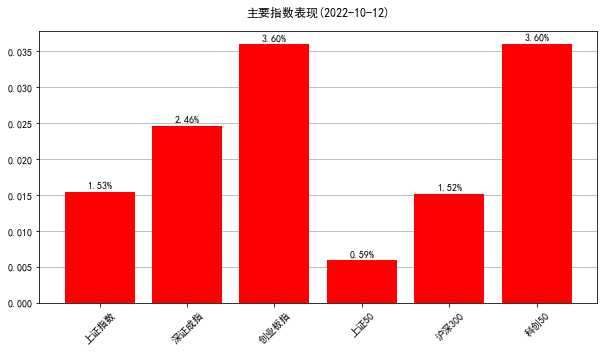

In [4]:
# 指数统计
mq.get_index_the_date_return()

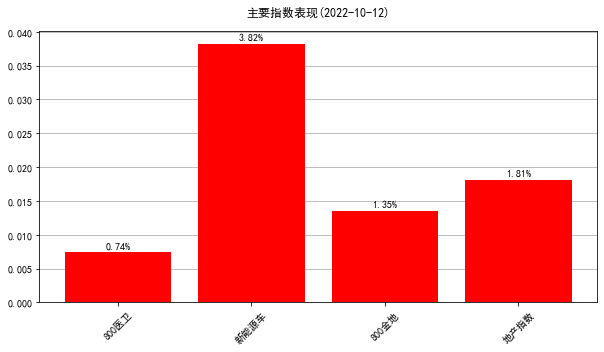

In [5]:
# 指数统计
mq.get_index_the_date_return(codes=['SHSE.000933','SZSE.399417','SHSE.000934','SZSE.399241'])

当前日期：2022-10-12    赚钱效应：93.12%
下跌： 335家    平盘：  34家    上涨：4537家
跌停：   0家    停牌：   6家    涨停：  80家
注：1、股票不包含北交所股票；
    2、涨幅为0的股票包含在(-2%,0%]中；
    3、部分涨跌停股票可能存在未彻底封板情况。


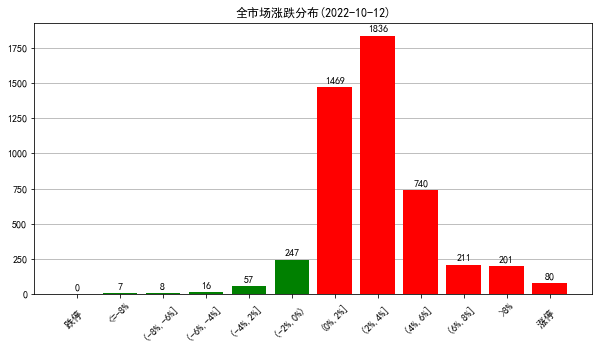

In [6]:
# 个股统计
mq.plot_distribution()

In [7]:
# 涨停股分析
mq.count_zt()

涨停：  80家    非一字涨停：  74家    封板率：76.19%


,股票代码,股票名称,首板时间,连板数,成交额/亿
1,SZSE.001269,欧晶科技,09:31,4,0.0676
2,SZSE.001255,博菲电气,09:31,4,0.0444
3,SZSE.002380,科远智慧,13:46,3,6.0660
4,SZSE.002395,双象股份,09:36,3,5.2414
5,SZSE.002093,国脉科技,09:31,3,0.7722
6,SZSE.002514,宝馨科技,13:57,2,21.1241
7,SZSE.000716,黑芝麻,14:48,2,10.1104
8,SHSE.600992,贵绳股份,14:56,2,8.2992
9,SZSE.002965,祥鑫科技,13:35,2,8.1205
10,SHSE.600869,远东股份,14:31,2,6.8737


In [8]:
# 量化模型择时
mq.cal_all_LLT()

注：LLT模型基于《MA超进化！LLT低延迟趋势线》文章，其中各指数的参数alpha均为0.05，LLT阈值为0，可自行调整参数。


,LLT模型结论
指数简称,
上证指数,涨
深证成指,涨
创业板指,跌
上证50,涨
沪深300,涨
科创50,涨


In [9]:
# 沪深300因子收益统计
mq.GuoXin_multiple_factor()


*************** 2022-10-12 沪深300 中各因子收益统计表 ***************


,因子名称,因子类型,因子方向,当天收益/%,当月收益/%
1,单季营收同比增速,成长,正向,3.0571,0.7145
2,非流动性冲击,流动性,反向,3.0278,-1.4146
3,三个月反转,反转,反向,2.7949,-3.1103
4,特异度,波动,反向,2.5615,-1.6288
5,EPTTM分位点,估值,正向,2.5084,-0.7543
6,单季净利同比增速,成长,正向,2.3190,-0.3123
7,一个月反转,反转,反向,2.2488,-5.3122
8,DELTAROE,盈利,正向,2.0937,-0.4767
9,BP,估值,正向,2.0854,-2.3371
10,单季营利同比增速,成长,正向,2.0635,-1.1453


In [ ]:
# 中证500因子收益统计
mq.GuoXin_multiple_factor(index_code='SHSE.000905',index_name='中证500',stocks_num=50)


*************** 2022-04-12中证500 中各因子收益统计表 ***************


,因子名称,因子类型,因子方向,当天收益/%,当月收益/%
1,一个月换手,流动性,反向,2.4480,-0.6065
2,三个月换手,流动性,反向,2.3161,-0.3318
3,特异度,波动,反向,2.2666,-4.7816
4,EPTTM分位点,估值,正向,2.1318,-5.1331
5,三个月反转,反转,反向,2.1112,-9.0819
6,非流动性冲击,流动性,反向,2.0179,-5.8319
7,DELTAROA,盈利,正向,1.9989,-4.2700
8,单季营收同比增速,成长,正向,1.9375,-1.1145
9,一个月反转,反转,反向,1.9332,-8.6117
10,三个月波动,波动,反向,1.8642,0.3708
